In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from PIL import Image
import seaborn
from sklearn.metrics import confusion_matrix
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [2]:
# khmer MNIST dataset
train = pd.read_csv('data/kh_char_train.csv', header=None)
test = pd.read_csv('data/kh_char_test.csv', header=None)

train.head()

,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,2304
0,CHHO,218,206,194,194,214,214,210,218,198,...,194,48,0,202,198,198,198,202,198,202
1,TA,241,241,255,255,255,255,255,255,255,...,0,13,45,81,122,136,145,159,163,163
2,NGO,183,163,122,142,142,163,163,163,193,...,142,173,183,183,153,142,142,163,153,153
3,KO,200,204,212,216,212,212,204,204,208,...,135,142,135,142,146,142,131,123,146,154
4,NGO,178,178,178,178,178,178,165,178,191,...,216,216,216,216,204,216,216,216,216,216


In [3]:
train[0] = train[0].astype('str')
test[0] = test[0].astype('str')

In [4]:
train[0].unique()

array(['CHHO', 'TA', 'NGO', 'KO', 'KHA', 'CHA', 'nan', 'DA', 'CHHA',
       'KHO'], dtype=object)

In [5]:
# create a dictionary to map the labels to integers
labels = train[0].unique()
labels_dict = {label: i for i, label in enumerate(labels)}
labels_dict

{'CHHO': 0,
 'TA': 1,
 'NGO': 2,
 'KO': 3,
 'KHA': 4,
 'CHA': 5,
 'nan': 6,
 'DA': 7,
 'CHHA': 8,
 'KHO': 9}

In [6]:
# replace the labels with integers
train[0] = train[0].replace(labels_dict)
test[0] = test[0].replace(labels_dict)

train.head(8)

/tmp/ipykernel_20035/753197256.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train[0] = train[0].replace(labels_dict)
/tmp/ipykernel_20035/753197256.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test[0] = test[0].replace(labels_dict)


,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,2304
0,0,218,206,194,194,214,214,210,218,198,...,194,48,0,202,198,198,198,202,198,202
1,1,241,241,255,255,255,255,255,255,255,...,0,13,45,81,122,136,145,159,163,163
2,2,183,163,122,142,142,163,163,163,193,...,142,173,183,183,153,142,142,163,153,153
3,3,200,204,212,216,212,212,204,204,208,...,135,142,135,142,146,142,131,123,146,154
4,2,178,178,178,178,178,178,165,178,191,...,216,216,216,216,204,216,216,216,216,216
5,1,191,181,186,186,186,196,196,196,201,...,191,191,186,73,0,0,9,127,156,171
6,1,124,176,194,194,191,194,197,197,194,...,255,255,255,255,255,255,255,255,255,255
7,1,210,210,204,216,223,216,216,242,235,...,0,0,25,76,102,51,0,38,159,172


In [7]:
train[0].dtype

dtype('int64')

In [8]:
train[0].value_counts()

0
1    4508
2    4296
5    2934
7    1430
3    1241
6    1207
4    1031
8     386
0     172
9     156
Name: count, dtype: int64

In [9]:
# split the training set into training and validation sets
train, val = train_test_split(train, stratify=train[0], test_size=0.5)

In [10]:
class KhmerDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.iloc[idx, 0]
        image = self.data.iloc[idx, 1:].values.reshape(48, 48).astype(np.uint8)

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (6, 24, 24)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # Output: (16, 20, 20)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (16, 10, 10)
        
        # Calculate the flattened size for fc1
        self.flattened_size = 16 * 10 * 10
        
        self.fc1 = nn.Linear(self.flattened_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [12]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean and std for grayscale images
])

train_dataset = KhmerDataset(train, transform=transform)
val_dataset = KhmerDataset(val, transform=transform)
test_dataset = KhmerDataset(test, transform=transform)

batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [14]:
num_classes = len(labels_dict)
model = LeNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 100

train_loss = []
val_loss = []

# training
for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    end_time = time.time()
    running_loss /= len(train_loader)
    train_loss.append(running_loss)

    val_running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images.float())
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()

    val_running_loss /= len(val_loader)
    val_loss.append(val_running_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {running_loss:.4f}, '
          f'Validation Loss: {val_running_loss:.4f}, '
          f'Time: {end_time - start_time:.2f} sec')

Epoch 1/100, Training Loss: 1.7067, Validation Loss: 1.1252, Time: 6.57 sec
Epoch 2/100, Training Loss: 0.7731, Validation Loss: 0.6011, Time: 6.42 sec
Epoch 3/100, Training Loss: 0.5058, Validation Loss: 0.4707, Time: 6.35 sec
Epoch 4/100, Training Loss: 0.4153, Validation Loss: 0.3976, Time: 6.31 sec
Epoch 5/100, Training Loss: 0.3407, Validation Loss: 0.3456, Time: 6.34 sec
Epoch 6/100, Training Loss: 0.2995, Validation Loss: 0.3109, Time: 6.42 sec
Epoch 7/100, Training Loss: 0.2613, Validation Loss: 0.2672, Time: 6.22 sec
Epoch 8/100, Training Loss: 0.2242, Validation Loss: 0.2576, Time: 6.33 sec
Epoch 9/100, Training Loss: 0.2112, Validation Loss: 0.2625, Time: 6.38 sec
Epoch 10/100, Training Loss: 0.1788, Validation Loss: 0.2510, Time: 6.21 sec
Epoch 11/100, Training Loss: 0.1627, Validation Loss: 0.2152, Time: 6.22 sec
Epoch 12/100, Training Loss: 0.1484, Validation Loss: 0.2232, Time: 6.26 sec
Epoch 13/100, Training Loss: 0.1234, Validation Loss: 0.2137, Time: 6.24 sec
Epoch 14

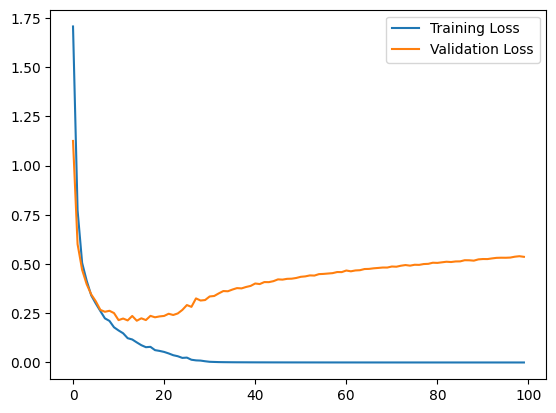

In [16]:
# plot the training and validation losses
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

In [17]:
# testing
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images.float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}')

Accuracy: 92.72557202475176


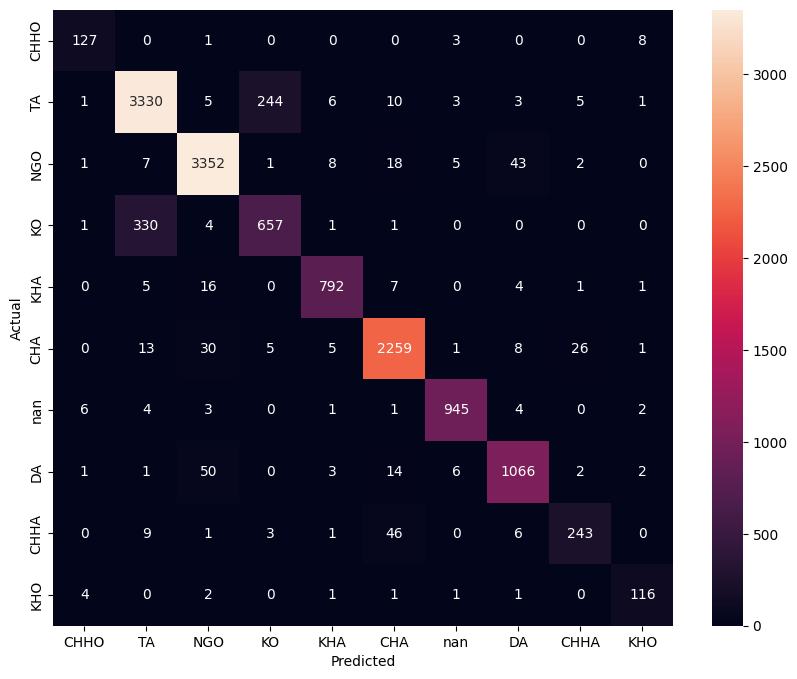

In [ ]:
# confusion matrix
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images.float())
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_dict.keys(), yticklabels=labels_dict.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
# save the model and everything
os.makedirs('LeNet save', exist_ok=True)
torch.save(model.state_dict(), 'LeNet save/model.pth')
torch.save(train_dataset, 'LeNet save/train_dataset.pth')
torch.save(val_dataset, 'LeNet save/val_dataset.pth')
torch.save(test_dataset, 'LeNet save/test_dataset.pth')
torch.save(labels_dict, 'LeNet save/labels_dict.pth')